## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B testing is essentially an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal.
My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df['converted'].sum() / len(df))*100

11.965919355605511

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now we will create a new dataset **df2** that meets the above specifications.

In [8]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0] + df.query("group != 'treatment' and landing_page == 'new_page'").shape[0]

3893

In [9]:
df.query("group == 'control' and landing_page != 'old_page'").shape[0] + df.query("group != 'control' and landing_page == 'old_page'").shape[0]

3893

In [10]:
df.query("group == 'control' and landing_page != 'old_page'").index

Int64Index([    22,    240,    490,    846,    850,    988,   1198,   1354,
              1474,   1877,
            ...
            293393, 293480, 293568, 293662, 293888, 293894, 293996, 294200,
            294253, 294331],
           dtype='int64', length=1928)

In [11]:
df.shape

(294478, 5)

In [12]:
df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, axis = 0,inplace = True)


In [13]:
df.drop(df.query("group != 'treatment' and landing_page == 'new_page'").index, axis = 0,inplace = True)
df.drop(df.query("group == 'control' and landing_page != 'old_page'").index, axis= 0,inplace = True)
df.drop(df.query("group != 'control' and landing_page == 'old_page'").index,axis = 0,inplace = True)

In [14]:
df2 = df.copy()

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [16]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [17]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
df2.shape

(290585, 5)

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.drop(labels = 2893,axis = 0,inplace = True)

In [20]:
df2.shape

(290584, 5)

a. What is the probability of an individual converting regardless of the page they receive?

In [21]:
df2['converted'].sum() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
control = df2.query("group == 'control'")

In [23]:
control['converted'].sum() / control.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
treatment = df2.query("group == 'treatment'")

In [25]:
treatment['converted'].sum() / treatment.shape[0]

0.11880806551510564

In [26]:
obs_diff = treatment['converted'].sum() / treatment.shape[0] - control['converted'].sum() / control.shape[0]
obs_diff

-0.0015782389853555567

>- **Negative difference between treatment & control group do suggest us that conversion rate of treament group is less than control group.**

d. What is the probability that an individual received the new page?

In [27]:
df2.query("landing_page == 'new_page'")['landing_page'].count() / df2.shape[0]

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

>- **We haven't yet find any evidence to claim that new treatment page leads to more conversion.To reach our result we should dive in more using hypothesis testing & regression model. **

<a id='ab_test'></a>
### Part II - A/B Test
`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> ##  **H0** : **$p_{new}$** <= **$p_{old}$**

> ##  **H1** : **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [28]:
pnew=df2['converted'].mean()
pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [29]:
pold=df2['converted'].mean()
pold

0.11959708724499628

c. What is $n_{new}$?

In [30]:
n_new=df2.query("landing_page =='new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [31]:
n_old=df2.query("landing_page =='old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
new_page_converted=np.random.binomial(n=1,p=pnew,size = n_new)
new_page_converted

array([1, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
old_page_converted = np.random.binomial(n = 1,p = pold, size =n_old )
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
pnew-pold


0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range(10000):
    boot_new_page_converted=np.random.binomial(n=1,p=pnew,size = n_new)
    boot_old_page_converted = np.random.binomial(n = 1,p = pold, size =n_old )
    p_diffs.append(boot_new_page_converted.mean() - boot_old_page_converted.mean())

In [36]:
p_diffs = np.array(p_diffs)


i. Plot a histogram of the **p_diffs**.  

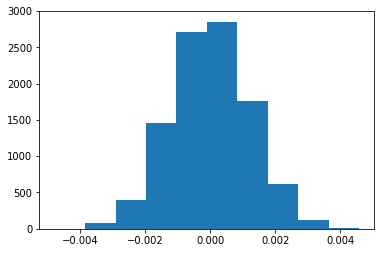

In [37]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [38]:
p_diffs = np.array(p_diffs)

In [39]:
(p_diffs>obs_diff).mean()

0.90690000000000004

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **Our Type 1 error is 5% & the probability we got is 0.9069 which Suggest that we have failed to reject the null & converation for new page is less or equal to the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [41]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [43]:
z_score, p_value = sm.stats.proportions_ztest([17489,17264], [145274, 145310],alternative = 'larger')

In [44]:
z_score , p_value

(1.3109241984234394, 0.094941687240975514)

In [45]:
from scipy.stats import norm

norm.cdf(z_score)
# Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
# Tells us what our critical value at 95% confidence is

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>- **Critical Value is larger than Z-score which again suggest us that we have failed to reject the null & that there is evidence of conversion for new page is less or equal to the old page**

<a id='regression'></a>
### Part III - A regression approach

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>- **Since here we have only two outcomes we should choose Logistic Regression.Because Logistic Regression is used for Categorical Response and to those who have only two outcomes possible.**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However,first we need to create a column for the intercept, and create a dummy variable column for which page each user received. Also we have to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
df2['intercept'] = 1
df2[['control','ab_page']]= pd.get_dummies(df2['group'])

In [48]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [49]:
df2.drop(labels = 'control',axis = 1, inplace= True)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [50]:
lg=sm.Logit(df2['converted'], df2[['intercept', 'ab_page' ]])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 12 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        17:28:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [51]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

>- **In treatment group chance of conversion of an individual is 0.9851 times less likely as compared to control group holding all other parameters constant. **

In [52]:
1 / np.exp(-0.0150)

1.0151130646157189

>-  **In control group chance of conversion of an individual is 1.0151 times more likely compared to treatment group holding all other parameters constant. **

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

>- **P-value we got in our Logistic model is 0.190 & it differs from the p-value of 0.9069 observed in bootstrapping approach. 
This happens because in Regression Model Null is **$B_{1}$ = 0**,Alternative is **$B_{1}$ != 0**.
Having p-value greater than 0.05 suggest us that conversion of ab_page(treatment group) is not different from control group or ab_page is not statistically significant in relation to conversion.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>- **Adding other factors will give us idea of how those independent variables are related to our response and it will also help in comparison of one another that will eventually give us more idea of our experiment**

>- **But if somehow the explonatory variables happens to correlate with one another the obtained results will surely mislead us**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [53]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [54]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [55]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [56]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [57]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [58]:
log_mod=sm.Logit(df_new['converted'], df_new[['intercept','CA','UK']])
results_mod = log_mod.fit()
results_mod.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 12 May 2018   Pseudo R-squ.:               1.521e-05
Time:                        17:28:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [59]:
np.exp(results_mod.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

>- **If an individual is from CA then rate of conversion is  0.9600 times less likely as compared to an individual from US.**

>- **Probability of 0.129 Suggest that:**

>- **There is no statistical significant evidence that rate of conversion of an individual from CA differs from rate of conversion of an individual from US **

>- **If an individual is from UK then rate of conversion is  1.0099 times more likely as comapred to an individual from US.**

>- **Probability of 0.456 Suggest that:**

>- **There is no statistical significant evidence that rate of conversion of an individual from UK differs from  rate of conversion of an idividual from US **


In [60]:
1/np.exp(-0.048)

1.0491706553244706

>- **If an individual is from US then chance of conversion is 1.0491 times more likely as compared to the individual from CA.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and conclusions based on the results.

In [61]:
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']

In [62]:
### Fit Your Linear Model And Obtain the Results
sm_model = sm.Logit(df_new['converted'] , df_new[['intercept','ab_page_UK','ab_page_CA','CA','UK','ab_page']])
results_model=sm_model.fit()
results_model.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 12 May 2018   Pseudo R-squ.:               3.482e-05
Time:                        17:28:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
==============================================================================
"""

In [63]:
np.exp(results_model.params)

intercept     0.137178
ab_page_UK    1.031896
ab_page_CA    0.954198
CA            0.982625
UK            0.994272
ab_page       0.979646
dtype: float64

>- **Basically we should not include interaction terms in logistic model,because the basic idea for interaction terms is we should include it in our model whenever the slope is no longer same but changes as per the coefficient say x2.**

>- **I assume this added in our project to check if student has understood the concepts.**

### **Summary**

> - **After adding the interaction term we won't be able to interpret the data as before.We can only predict the data which is not related to the interaction terms but here in our summary there is no such data.**

> - **There is statistical evidence that conversion rate in UK & CA does not differ from US Also conversion rate in treatment group is not different from conversion rate in control group.**


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [65]:
X = df_new[['ab_page','CA','UK',"US"]]
y = df_new['converted']

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 1)

In [67]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_preds=logreg.predict(X_test)
metrics.accuracy_score(y_test,y_preds)

0.8803099964210005

>- **Our model has acheived 88.03% accuracy.**

In [72]:
df['days'] = pd.to_datetime(df['timestamp']) 

In [73]:
df['days'].max() - df['days'].min()

Timedelta('21 days 23:59:49.081927')

## **Conclusions**
**In my complete analysis, I found the evidence that chance of conversion on new page is less or equal to the old page.The duration of the experiment has also been for 21days so aversion,novelty wouldn't have affected our analysis.For a higher conversion rate company should come up with new ideas. But for now they should keep the old page.**